In [8]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import t
from byutpl.properties import air
from byutpl.properties import water
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

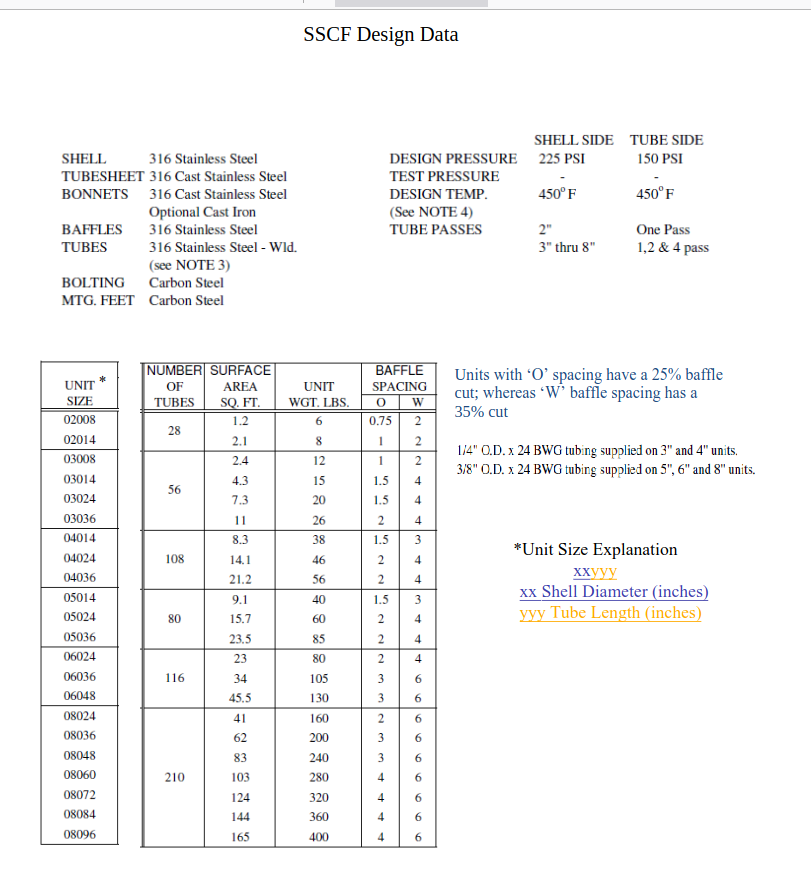

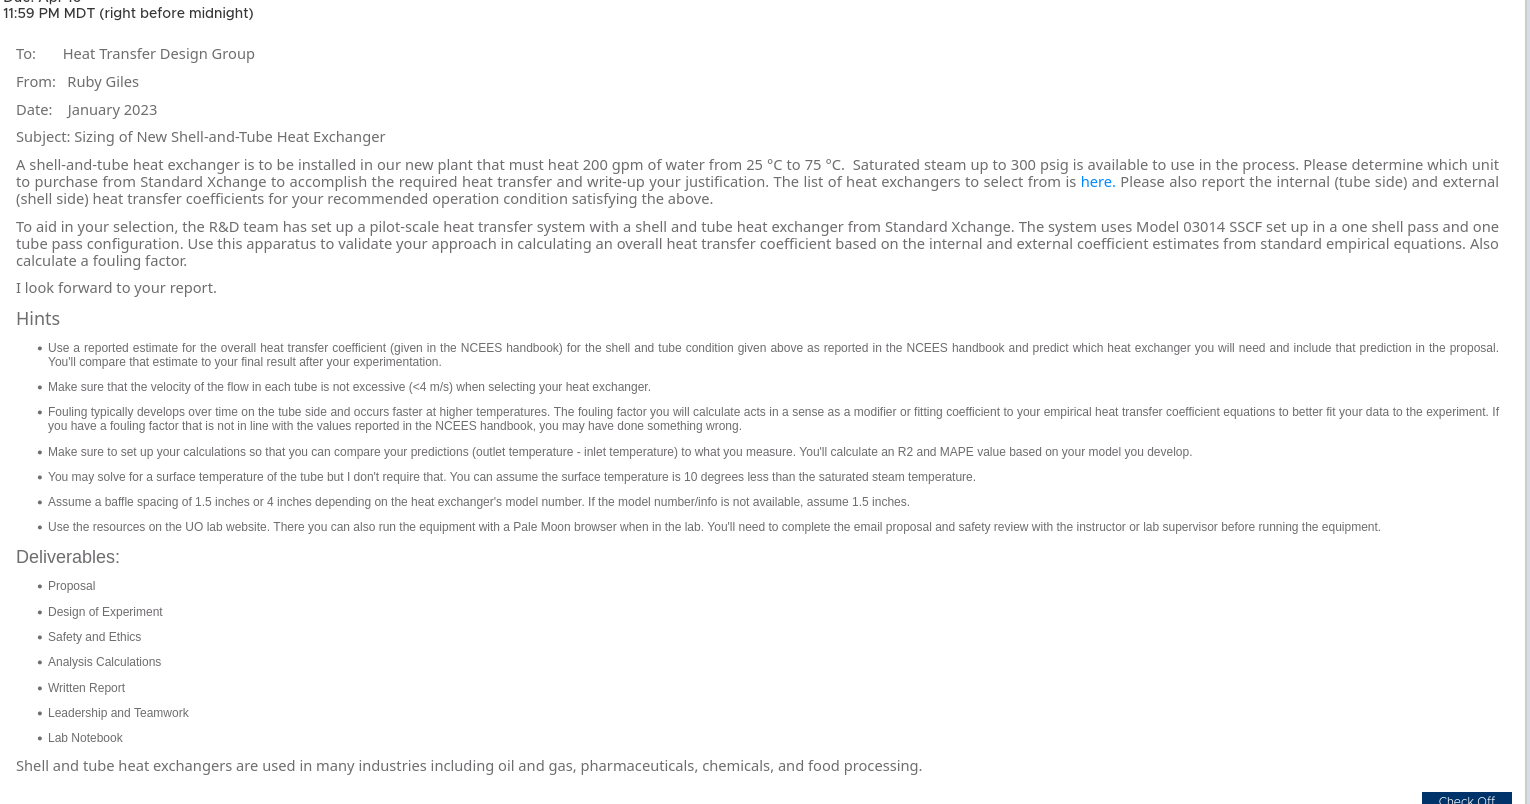

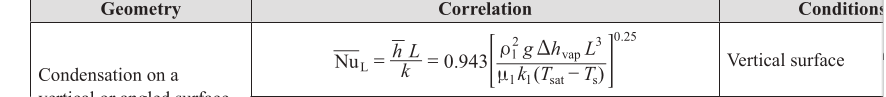

In [3]:
#model 03014
Ntube = 56 
A = 4.3 / 10.764 #square meters good enough for both inner and outer
baffle = 1.5
d1 = 0.005 #m
r1 = d1/2 #m
d2 = 0.006 #m
r2 = d2/2
t = r2-r1
Ac1 = np.pi*r1**2
L = 14 / 3.281 #m

#k steel
ks = 24.80 #W/mk

# System Details
Vdot = 20 / 15850.323140625002 #m^3/s
Tin = 25 + 273.15 #k
Tout = 75 + 273.15 #k
Tavg = (Tin+Tout)/2
Vinner = Vdot/(Ac1*Ntube)
print("Water Velocity in the tubes is:", Vinner, "m/s")

Psteam = (300+12.5) * 6894.76 #pa
Tsteam = water.tsat(Psteam)
Ts = Tsteam - 10 #k 

print("Saturated Steam Temp:", Tsteam-273.15,"C")

#h water dittus/Boelter
nuinner = water.lnu(Tavg)
Prinner = water.lpr(Tavg)
kinner = water.ltc(Tavg)

Reinner = Vinner*d1/nuinner

print("Reynolds for the flow in the tubes =",Reinner)
print("Prandlt number for flow in the tubes=",Prinner)

Nuinner = 0.023*Reinner**(0.8)*Prinner**0.4

print("Nu in tubes is", Nuinner)

hi = Nuinner*kinner/d1

print("h for the inner tube is", hi, "W/m^2k")

#h for the steam side
hfg_p = (water.hvp(Tsteam) + 0.68*water.lcp(Tsteam)*(Tsteam-Ts)) / water.mw
Nrows = 5

rol = water.ldn(Tsteam)
rov = water.vdn(Tsteam, Psteam)
kl = water.ltc(Tsteam)
mul = water.lvs(Tsteam)
g = 9.8 #m/s

NuL = 0.943*( (rol**2*g*hfg_p*L**3) / (mul*kl*(Tsteam-Ts)))**0.25

hsteam = NuL*kl/L

print("h for steam side is", hsteam, "W/m^2k")

# Scaling Resistance
RFi = 0.00018/A #(m2 ⋅ K/W)
RFo = 0.00009/A #(m2 ⋅ K/W)

# Find other resistances
Ri = 1/(A*hi)
Ro = 1/(A*hsteam)
Rc = np.log(d2/d1)/(2*np.pi*ks*L*Ntube) # for now because I don't think I can to this as easily in cylindrical, and it's probably small

UA = 1/ ( Ri + RFi + Rc + RFo + Ro)
U = UA/A

print("")
print("Ri, RFi, Rc, RFo, Ro", Ri, RFi, Rc, RFo, Ro)

print("Overall heat transfer coefficient =", U)
#Range of U for steam condenser from textbook 1000-6000
#Range of U for steam condenser from NCEES 1100–5600



Water Velocity in the tubes is: 1.1475561849423748 m/s
Saturated Steam Temp: 216.63264746646712 C
Reynolds for the flow in the tubes = 10131.12249519436
Prandlt number for flow in the tubes= 3.666437001879742
Nu in tubes is 61.93720167682047
h for the inner tube is 7896.282284147325 W/m^2k
h for steam side is 4848.48204079629 W/m^2k

Ri, RFi, Rc, RFo, Ro 0.00031701701178782024 0.00045058604651162794 4.896622671359125e-06 0.00022529302325581397 0.0005162968106080406
Overall heat transfer coefficient = 1653.3076739698863


In [4]:
#Sizing
Tin = 25 + 273.15 #k
Tout = 75 + 273.15 #k
Tavg = (Tin+Tout)/2
# U = 1613 # W/m^2kfrom above

# Tsteam = 216+273.15 #k
Vdot = 200 / 15850 #m^3/s

rol = water.ldn(Tavg) #kg/m^3
Mdot = Vdot*rol #kg/s
lcp = water.lcp(Tavg) / water.mw #J/kgk

q = Mdot*lcp*(Tout-Tin) #W

print("Overall heat transfer coefficient =", U)
print("q heating required", q, "w")

dT1 = Tsteam-Tout #k
dT2 = Tsteam-Tin #k

dTlm = (dT2-dT1)/np.log(dT2/dT1) #k

print("dTlm", dTlm, "k")
F = 1 #phase change

A = q/(U*F*dTlm) #m^2

print("Required area for heat transfer is", A*10.7639, "ft^2")
print("Based on this information you would need model 08072 heat exchanger or bigger")

#error bar
error = 0.25 #based of the 25% error of the correlations and the extra error from assumptions
Ulow = U-error*U
Uhigh= U+error*U
Abig = q/(Ulow*F*dTlm)
Asmall = q/(Uhigh*F*dTlm)

print("The estimation for U based on the correlations involved a lot of error, so we would expect the actual required size to be between")
print(Asmall*10.4639, "and", Abig*10.4639, "ft^2")
print("In order to find a more exact range we need more data")

Overall heat transfer coefficient = 1653.3076739698863
q heating required 2603572.373177094 w
dTlm 165.37479787985063 k
Required area for heat transfer is 102.49821469472239 ft^2
Based on this information you would need model 08072 heat exchanger or bigger
The estimation for U based on the correlations involved a lot of error, so we would expect the actual required size to be between
79.71319456658689 and 132.85532427764485 ft^2
In order to find a more exact range we need more data


### Finding U for a variety of flow regimes

In [5]:
# Replace 'file_path.csv' with the path to your CSV file
file_path = 'S&T Data.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Displaying the first few rows of the DataFrame
print(df.head())

          Trial Name  Water Level (ft)  Water Flowrate (GPM)  \
0  40 GPM 10 psi - 1          1.515572             40.263118   
1  40 GPM 10 psi - 2          1.496061             39.988217   
2  40 GPM 10 psi - 3          1.495538             40.411198   
3  40 GPM 20 psi - 3          1.426496             40.269833   
4  40 GPM 30 psi - 1          1.450538             40.504815   

   House Steam Pressure (psig)  Steam Pressure (psig)  \
0                    52.565842              20.042477   
1                    52.259744              10.072887   
2                    53.785361              10.063502   
3                    54.067088              20.148925   
4                    51.420964              24.094477   

   Inlet Water Temperature (C)  Outlet Water Temperature (C)  
0                    25.603768                     33.854407  
1                    35.088209                     41.811578  
2                    42.482665                     48.821623  
3                   

In [6]:
def find_U(vdot, steamP, inletT, outletT):
    iT = inletT + 273.15 #k
    oT = outletT + 273.15 #k
    sP = (steamP + 12.5)*6894.76 #pa
    vD = vdot * 6.309E-5 #m^3/s
    Tsteam = water.tsat(sP) #K
    
    dT1 = Tsteam-oT #k
    dT2 = Tsteam-iT #k
    dTlm = (dT2-dT1)/np.log(dT2/dT1) #k
    F = 1 #phase change
    A = 4.3 / 10.764 #m^2
    Tavg = (iT+oT)/2
    lcp = water.lcp(Tavg) / water.mw #J/kgk
    rol = water.ldn(Tavg) #kg/m^3
    mD = vD*rol #kg/s
    q = mD*lcp*(oT-iT) #W

    U = q/(A*F*dTlm) #w/m^2k
    return U


U_test = find_U(40.2631,20.042,25.603,33.85)
    
print("U_test=",U_test)

U_test= 2287.4446535779775


In [9]:
vdot_arr = df['Water Flowrate (GPM)'].values
steamP_arr = df['Steam Pressure (psig)'].values
inletT_arr = df['Inlet Water Temperature (C)'].values
outletT_arr = df['Outlet Water Temperature (C)'].values

U_arr = np.zeros(len(vdot_arr))
for i in range(len(U_arr)):
    U_arr[i] = find_U(vdot_arr[i],steamP_arr[i],inletT_arr[i],outletT_arr[i])    

df['U (W/m^2k)'] = U_arr

U_avg = np.mean(U_arr)
U_stddev = np.std(U_arr)

p_value = 0.05
DOF = len(U_arr)-1

t_stat = t.ppf(1-p_value/2,df=DOF)

err = t_stat*U_stddev/np.sqrt(len(U_arr))

print("The average U over 39 Temp and Flow Regimes:", U_avg, "(W/m^2k)")
print("The standard deviation of U is:", U_stddev, "(W/m^2k)")
print("The margin of Error is:", err, "(W/m^2k)")


The average U over 39 Temp and Flow Regimes: 2298.5038210191683 (W/m^2k)
The standard deviation of U is: 331.6697966697215 (W/m^2k)
The margin of Error is: 112.22091396339677 (W/m^2k)


### Now find the fouling factor

In [10]:
def find_Sfoul(vdot, steamP, inletT, outletT, U):
    #model 03014
    Ntube = 56 
    A = 4.3 / 10.764 #square meters good enough for both inner and outer
    baffle = 1.5
    d1 = 0.005 #m
    r1 = d1/2 #m
    d2 = 0.006 #m
    r2 = d2/2
    t = r2-r1
    Ac1 = np.pi*r1**2
    L = 14 / 3.281 #m
    
    #k steel
    ks = 24.80 #W/mk
    
    # System Details
    iT = inletT + 273.15 #k
    oT = outletT + 273.15 #k
    sP = (steamP + 12.5)*6894.76 #pa
    vD = vdot * 6.309E-5 #m^3/s
    Tsteam = water.tsat(sP) #K
    
    Tavg = (iT+oT)/2
    vin = vD/(Ac1*Ntube)

    Ts = Tsteam - 10 #k 
    
    #h water dittus/Boelter
    nuinner = water.lnu(Tavg)
    Prinner = water.lpr(Tavg)
    kinner = water.ltc(Tavg)
    
    Reinner = vin*d1/nuinner
    
    Nuinner = 0.023*Reinner**(0.8)*Prinner**0.4
    
    hi = Nuinner*kinner/d1
    
    #h for the steam side
    hfg_p = (water.hvp(Tsteam) + 0.68*water.lcp(Tsteam)*(Tsteam-Ts)) / water.mw
    
    rol = water.ldn(Tsteam)
    rov = water.vdn(Tsteam, sP)
    kl = water.ltc(Tsteam)
    mul = water.lvs(Tsteam)
    g = 9.8 #m/s
        
    NuL = 0.943*( (rol**2*g*hfg_p*L**3) / (mul*kl*(Tsteam-Ts)))**0.25
    
    hsteam = NuL*kl/L
    
    # Scaling Resistance
    RFig = 0.0002/A #(m2 ⋅ K/W)
    RFo = 0 #according to boss #(m2 ⋅ K/W)

    def solve_R(RFig):
        # Find other resistances
        Ri = 1/(A*hi)
        Ro = 1/(A*hsteam)
        Rc = np.log(d2/d1)/(2*np.pi*ks*L*Ntube)
        UA = 1/ ( Ri + RFig + Rc + RFo + Ro)
        U_test = UA/A
        return U-U_test

    RFi = fsolve(solve_R,RFig)[0]
    Sf = RFi*A
    return Sf

test = find_Sfoul(40.2631,20.042,25.603,33.85,2000)

print(test)
    

0.0002028872613334031


In [11]:
vdot_arr = df['Water Flowrate (GPM)'].values
steamP_arr = df['Steam Pressure (psig)'].values
inletT_arr = df['Inlet Water Temperature (C)'].values
outletT_arr = df['Outlet Water Temperature (C)'].values
U_arr = df['U (W/m^2k)'].values

SFi_arr = np.zeros(len(vdot_arr))
for i in range(len(vdot_arr)):
    SFi_arr[i] = find_Sfoul(vdot_arr[i], steamP_arr[i], inletT_arr[i], outletT_arr[i], U_arr[i])    

df['SFi'] = SFi_arr
df.to_csv('S&T Analyzed.csv', index=False)
SFi_avg = np.mean(SFi_arr)
SFi_stddev = np.std(SFi_arr)

p_value = 0.05
DOF = len(U_arr)-1

t_stat = t.ppf(1-p_value/2,df=DOF)

err = t_stat*SFi_stddev/np.sqrt(len(SFi_arr))

print("The average SFi over 36 Temp and Flow Regimes:", SFi_avg, "(W/m^2k)")
print("The standard deviation of U is:", SFi_stddev, "(W/m^2k)")
print("The margin of Error is:", err, "(W/m^2k)")

The average SFi over 36 Temp and Flow Regimes: 0.00016798222242953378 (W/m^2k)
The standard deviation of U is: 0.00015920809077718087 (W/m^2k)
The margin of Error is: 5.386826788805919e-05 (W/m^2k)


### Now we should predict using a model the outlet T

In [15]:
def simple_model(vdot, steamP, inletT):
    iT = inletT + 273.15 #k
    sP = (steamP + 12.5)*6894.76 #pa
    vD = vdot * 6.309E-5 #m^3/s
    Tsteam = water.tsat(sP) #K
    oTguess = iT + 15 #k
    A = 4.3 / 10.764 #m^2

    def solve_oT(oTg):
        dT1 = Tsteam-oTg #k
        dT2 = Tsteam-iT #k
        dTlm = (dT2-dT1)/np.log(dT2/dT1) #k
        F = 1 #phase change
        Tavg = (iT+oTg)/2
        lcp = water.lcp(Tavg) / water.mw #J/kgk
        rol = water.ldn(Tavg) #kg/m^3
        mD = vD*rol #kg/s
        qflow = mD*lcp*(oTg-iT) #W
        qcorr = U_avg*A*F*dTlm #W
        return qflow-qcorr
        
    oT = fsolve(solve_oT,oTguess)[0]-273.15

    return oT

def complex_model(vdot, steamP, inletT):
    iT = inletT + 273.15 #k
    sP = (steamP + 12.5)*6894.76 #pa
    vD = vdot * 6.309E-5 #m^3/s
    Tsteam = water.tsat(sP) #K
    oTg = iT + 10 #k
    A = 4.3 / 10.764 #m^2

    #model 03014
    Ntube = 56 
    A = 4.3 / 10.764 #square meters good enough for both inner and outer
    baffle = 1.5
    d1 = 0.005 #m
    r1 = d1/2 #m
    d2 = 0.006 #m
    r2 = d2/2
    t = r2-r1
    Ac1 = np.pi*r1**2
    L = 14 / 3.281 #m
    
    #k steel
    ks = 24.80#W/mk
    
    Tavg = (iT+oTg)/2
    vin = vD/(Ac1*Ntube)

    Ts = Tsteam - 10 #k 
    
    #h water dittus/Boelter
    nuinner = water.lnu(Tavg)
    Prinner = water.lpr(Tavg)
    kinner = water.ltc(Tavg)
    
    Reinner = vin*d1/nuinner
    
    Nuinner = 0.023*Reinner**(0.8)*Prinner**0.4
    
    hi = Nuinner*kinner/d1
    
    #h for the steam side
    hfg_p = (water.hvp(Tsteam) + 0.68*water.lcp(Tsteam)*(Tsteam-Ts)) / water.mw
    
    rol = water.ldn(Tsteam)
    rov = water.vdn(Tsteam, sP)
    kl = water.ltc(Tsteam)
    mul = water.lvs(Tsteam)
    g = 9.8 #m/s
        
    NuL = 0.943*( (rol**2*g*hfg_p*L**3) / (mul*kl*(Tsteam-Ts)))**0.25
    
    hsteam = NuL*kl/L
    
    # Scaling Resistance
    RFi = SFi_avg/A #(m2 ⋅ K/W)
    RFo = 0 #according to boss #(m2 ⋅ K/W)
    Ri = 1/(A*hi)
    Ro = 1/(A*hsteam)
    Rc = np.log(d2/d1)/(2*np.pi*ks*L*Ntube)
    UA = 1/ ( Ri + RFi + Rc + RFo + Ro)
    
    def solve_oT(oTg):
        dT1 = Tsteam-oTg #k
        dT2 = Tsteam-iT #k
        dTlm = (dT2-dT1)/np.log(dT2/dT1) #k
        F = 1 #phase change
        Tavg = (iT+oTg)/2
        lcp = water.lcp(Tavg) / water.mw #J/kgk
        rol = water.ldn(Tavg) #kg/m^3
        mD = vD*rol #kg/s
        qflow = mD*lcp*(oTg-iT) #W
        qcorr = UA*F*dTlm #W
        return qflow-qcorr

    oT = fsolve(solve_oT,oTg)[0] -273.15

    return oT
    
oT_test_simple = simple_model(40.2631,20.042,25.603) #33.85
oT_test_complex = complex_model(40.2631,20.042,25.603) #33.85
    
print("oT simple=", oT_test_simple)
print("oT complex=", oT_test_complex)

    

oT simple= 33.888235150994376
oT complex= 33.278833409068795


The MAPE of the simple model using constant U is: 1.2594956658094507
The MAPE of the complex model using constant fouling factor and variable U that depends on flow is: 1.1427564685232892
R2 of the simple model is: 0.9951870603826795
R2 of the complex model is 0.9961102025572693


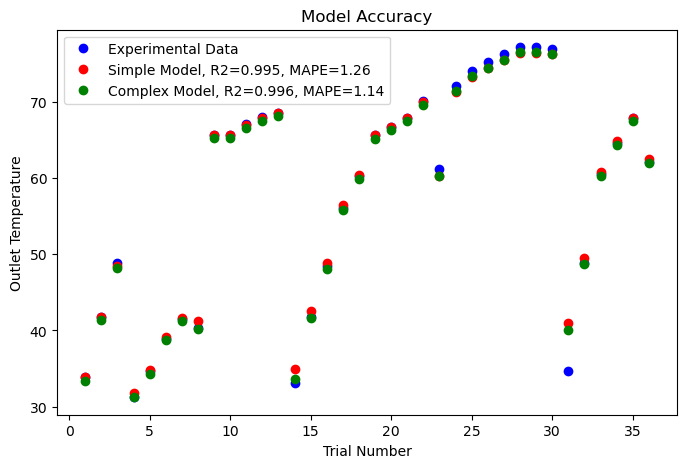

In [14]:
trial_arr = df['Trial Name'].values
vdot_arr = df['Water Flowrate (GPM)'].values
steamP_arr = df['Steam Pressure (psig)'].values
inletT_arr = df['Inlet Water Temperature (C)'].values
outletT_arr = df['Outlet Water Temperature (C)'].values

oT_complex_arr = np.zeros(len(vdot_arr))
oT_simple_arr = np.zeros(len(vdot_arr))
for i in range(len(vdot_arr)):
    oT_complex_arr[i] = complex_model(vdot_arr[i], steamP_arr[i], inletT_arr[i])
    oT_simple_arr[i] = simple_model(vdot_arr[i], steamP_arr[i], inletT_arr[i])

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape_complex = mean_absolute_percentage_error(outletT_arr, oT_complex_arr)
mape_simple = mean_absolute_percentage_error(outletT_arr, oT_simple_arr)

# Calculate linear regression
slope_simple, intercept_simple, r_value_simple, p_value_simple, std_err_simple = linregress(outletT_arr, oT_simple_arr)
slope_complex, intercept_complex, r_value_complex, p_value_complex, std_err_complex = linregress(outletT_arr, oT_complex_arr)

# Calculate R-squared
r_squared_simple = r_value_simple**2
r_squared_complex= r_value_complex**2

print("The MAPE of the simple model using constant U is:", mape_simple)
print("The MAPE of the complex model using constant fouling factor and variable U that depends on flow is:", mape_complex)

print("R2 of the simple model is:", r_squared_simple)
print("R2 of the complex model is", r_squared_complex)

trial = np.linspace(1,len(trial_arr),len(trial_arr))

plt.figure(figsize=(8,5))
plt.title("Model Accuracy")
plt.plot(trial, outletT_arr, "bo", label="Experimental Data")
plt.plot(trial, oT_simple_arr, "ro", label="Simple Model, R2=0.995, MAPE=1.26")
plt.plot(trial, oT_complex_arr, "go", label="Complex Model, R2=0.996, MAPE=1.14")
plt.xlabel("Trial Number")
plt.ylabel("Outlet Temperature")
plt.legend()
plt.savefig('Model Accuracy.png')
plt.show()

